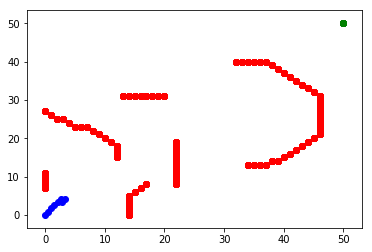

path_planner: unfiltered = [229.64829710703452, 210.01788024830094, 275.6499388513427, 443.46460175257994, 664.4543926009112, 920.5056400821187, 1092.5196800679469, 1094.0087691302247, 961.2555628618634, 828.5023565935022, 625.6262370593889, 385.00602935232405]
path_planner: filtered < 200 = []
path_planner: after filtering, sectors = []


IndexError: list index out of range

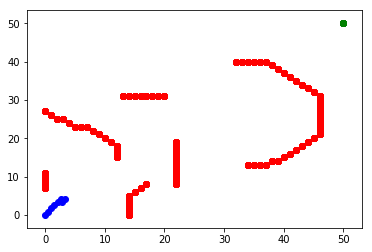

In [1]:
import matplotlib.pyplot as plt


%load_ext autoreload
%autoreload 2
%matplotlib inline


# from lib.polar_histogram import PolarHistogram
# from lib.histogram_grid import HistogramGrid
# from lib.path_planner import PathPlanner
from lib.robot import Robot

# HistogramGrid params
active_region_dimension = (30, 30)
resolution = 1 # 1cm per node
map_fname = 'map.txt'

# PolarHistogram params
num_bins = 12 # each bin is 36 degrees
target_location = (50, 50)

# Robot Params
init_location = (0, 0)
init_speed = 1

robot = Robot.from_map(map_fname, init_location, target_location, init_speed, active_region_dimension, resolution, num_bins)

num_steps = 100

robot.loop(num_steps, draw=True)
# print(path_planner)
# robot.path_planner.print_histogram()
# robot.draw()
# print(robot.angle)